This is the Python code written to implement sequency domain filtering for the blog post on [Junction Point](https://junctionpoint.github.io) Created by JunctionPoint on 31-03-2023, edited on 26-07-2023.

The required packages can be installed by running the following commands:

- `conda install -c conda-forge python-sounddevice`
- `conda install -c conda-forge pysoundfile`
- `conda install numpy`
- `conda install scipy`
- `conda install matplotlib`

In [2]:
import sounddevice as sd
import soundfile as sf
import numpy as np
from scipy.io.wavfile import write
from scipy.linalg import hadamard
from matplotlib import pyplot as plt

In [2]:
# Record audio
fs = 2**13  # Sample rate
seconds = 2  # Duration of recording

print("Starting to record...")
sound = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished
# write("recording.wav",fs,sound)

In [3]:
# Load the recorded audio for further steps
sound, fs = sf.read("recording.wav")

In [ ]:
sd.play(sound, fs)

In [4]:
# Create the H_n Hadamard matrix where n=14
H = hadamard(2**14, dtype="int8")

# Try lowering int size if the kernel crashes.

In [11]:
"""
Compute the sequency of each row given a Hadamard matrix by:
1) Create a copy of the row and shift left by one element
2) Sum the overlapping elements (length-1 should overlap)
3) Count the number of times where the sum is zero
4) Record that count as the sequency of that row
5) Repeat for each row
"""
def compute_sequency(matrix):
    m, n = matrix.shape
    sequency = np.zeros(m)
    for i in range(m):
        row = matrix[i]
        sequency[i] = np.sum((row[0:-1] + row[1:]) == 0)

    return sequency.astype("int16") # returns the sequency vector

In [12]:
seq = compute_sequency(H)
print(f"Sequency vector is of shape {seq.shape} with "
      f"{np.unique(seq).size} unique elements")
print(f"First few elements of the sequency vector:\n{seq[0:8]}")

Sequency vector is of shape (16384,) with 16384 unique elements
First few elements of the sequency vector:
[    0 16383  8191  8192  4095 12288  4096 12287]


In [13]:
"""
Sort a given Hadamard matrix according to its sequency
Returns sequency-ordered Hadamard matrix
"""
def sort_hadamard(matrix, sequency):
    m, n = matrix.shape
    # Copy to avoid changes in the matrix passed originally
    mm = matrix.copy()
    old_row = np.arange(m)
    mm[sequency] = mm[old_row]
    return mm

In [20]:
H_sorted = sort_hadamard(H, seq)
seq_sorted = compute_sequency(H_sorted)
print(f"First few elements of the SORTED sequency vector:\n{seq_sorted[0:8]}")

First few elements of the SORTED sequency vector:
[0 1 2 3 4 5 6 7]


In [21]:
# Get the coefficients in Hadamard domain by y = Hx
y = np.dot(H_sorted, sound)

# LPF indices
lpf_indices = np.around(np.flip(np.geomspace(1, 2**4, 5) * 2**9)).astype(int)

# Apply low-pass filtering by setting elements above `threshold` to zero
def lpf(y, threshold):
    yy = y.copy()
    yy[threshold:] = 0
    # print(np.sum(yy == 0)) # sanity check
    return yy

y_lpf = [lpf(y, lpf_idx) for lpf_idx in lpf_indices]

# BPF indices
bpf_indices = np.cumsum(lpf_indices)

# Apply band-pass filtering by setting below `threshold/2` and above
# `-threshold/2` to zero
def bpf(y, threshold):
    yy = y.copy()
    yy[0:threshold//2] = 0
    yy[-threshold//2:] = 0
    # print(np.sum(yy == 0)) # sanity check
    return yy

y_bpf = [bpf(y, bpf_idx) for bpf_idx in bpf_indices]

In [11]:
lpf_indices

array([8192, 4096, 2048, 1024,  512])

In [12]:
np.log2(y.size)

14.0

In [22]:
"""
Apply the inverse Hadamard transform xhat=Hy
For a given full Hadamard matrix it should be xhat=x because:
H=H^(-1) -> xhat = Hy = H(Hx) = H^(-1)(Hx) = x
"""
def inv_hadamard(signal, H):
    x = np.dot(H, signal)
    # Normalize as if the original Hadamard was orthonormal
    scale = signal.size
    return x / scale

xhat = inv_hadamard(y, H_sorted)
x_lpf = [inv_hadamard(y, H_sorted) for y in y_lpf]
x_bpf = [inv_hadamard(y, H_sorted) for y in y_bpf]

In [27]:
# Play the original sound
sd.play(sound, fs)

In [57]:
# Play low-pass filtered sound 1/2
sd.play(x_lpf[0], fs)

In [58]:
# Play low-pass filtered sound 1/4
sd.play(x_lpf[1], fs)

In [60]:
# Play low-pass filtered sound 1/8
sd.play(x_lpf[2], fs)

In [61]:
# Play low-pass filtered sound 1/16
sd.play(x_lpf[3], fs)

In [62]:
# Play low-pass filtered sound 1/32
sd.play(x_lpf[4], fs)

In [68]:
# Play band-pass filtered sound 1/2
sd.play(x_bpf[0], fs)

In [70]:
# Play band-pass filtered sound 1/4
sd.play(x_bpf[1], fs)

In [71]:
# Play band-pass filtered sound 1/8
sd.play(x_bpf[2], fs)

In [23]:
# Play band-pass filtered sound 1/16
sd.play(x_bpf[3], fs)

In [24]:
# Play band-pass filtered sound 1/32
sd.play(x_bpf[4], fs)

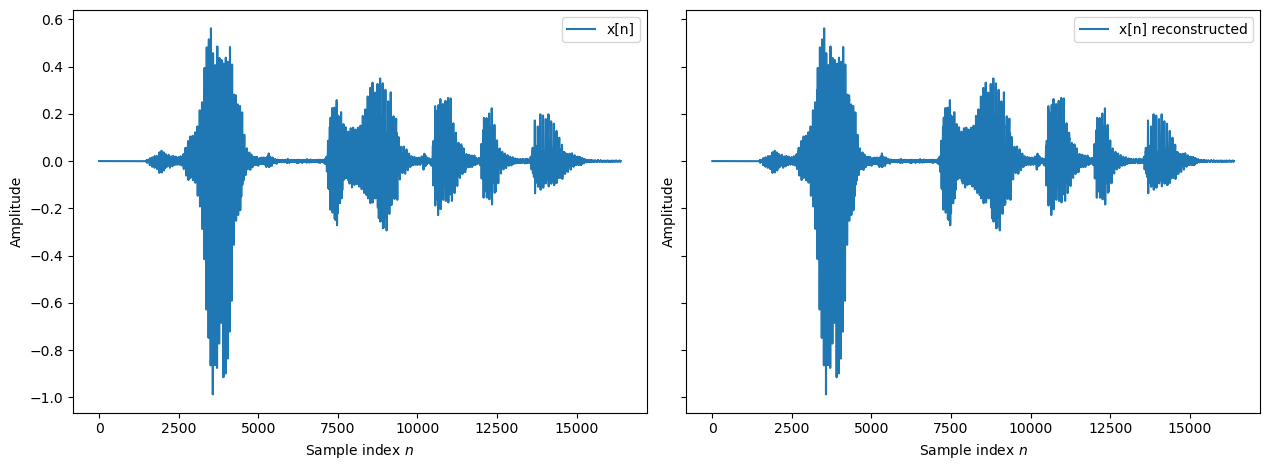

In [24]:
# Plot the original signal
fig, ax = plt.subplots(1,2, sharey=True)
ax[0].plot(sound, label='x[n]')
ax[0].set_xlabel(r'Sample index $n$')
ax[0].set_ylabel('Amplitude')
ax[0].legend(loc='upper right')


# Plot the reconstructed signal which is:
# y = Hx
# xhat = Hy
ax[1].plot(xhat, label='x[n] reconstructed')
ax[1].set_xlabel(r'Sample index $n$')
ax[1].set_ylabel('Amplitude')
ax[1].legend(loc='upper right')

fig.set_size_inches(6.4*2, 4.8)
fig.tight_layout()
fig.savefig("hadamard-1" + '.png', dpi=100)
plt.show()

/tmp/ipykernel_5613/207694456.py:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax.stem(np.abs(y/np.sqrt(y.size)), label='y[n]', markerfmt=" ",


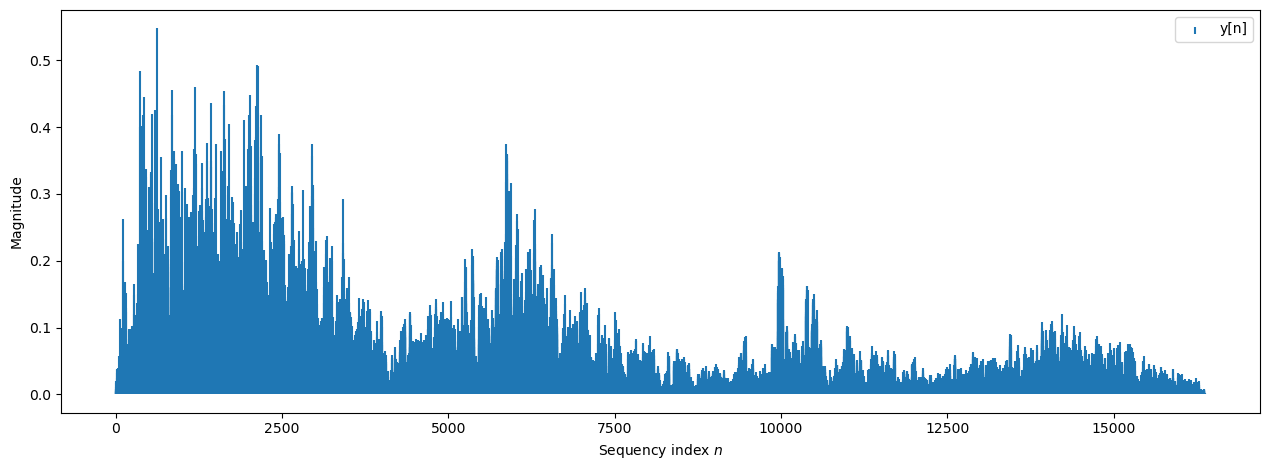

In [26]:
# Plot the original signal
fig, ax = plt.subplots()

# Plot the Hadamard coefficients y
ax.stem(np.abs(y/np.sqrt(y.size)), label='y[n]', markerfmt=" ",
        basefmt=" ", use_line_collection=True)
ax.set_xlabel(r'Sequency index $n$')
ax.set_ylabel('Magnitude')
ax.legend(loc='upper right')

fig.set_size_inches(6.4*2, 4.8)
fig.tight_layout()
fig.savefig("hadamard-2" + '.png', dpi=100)
plt.show()

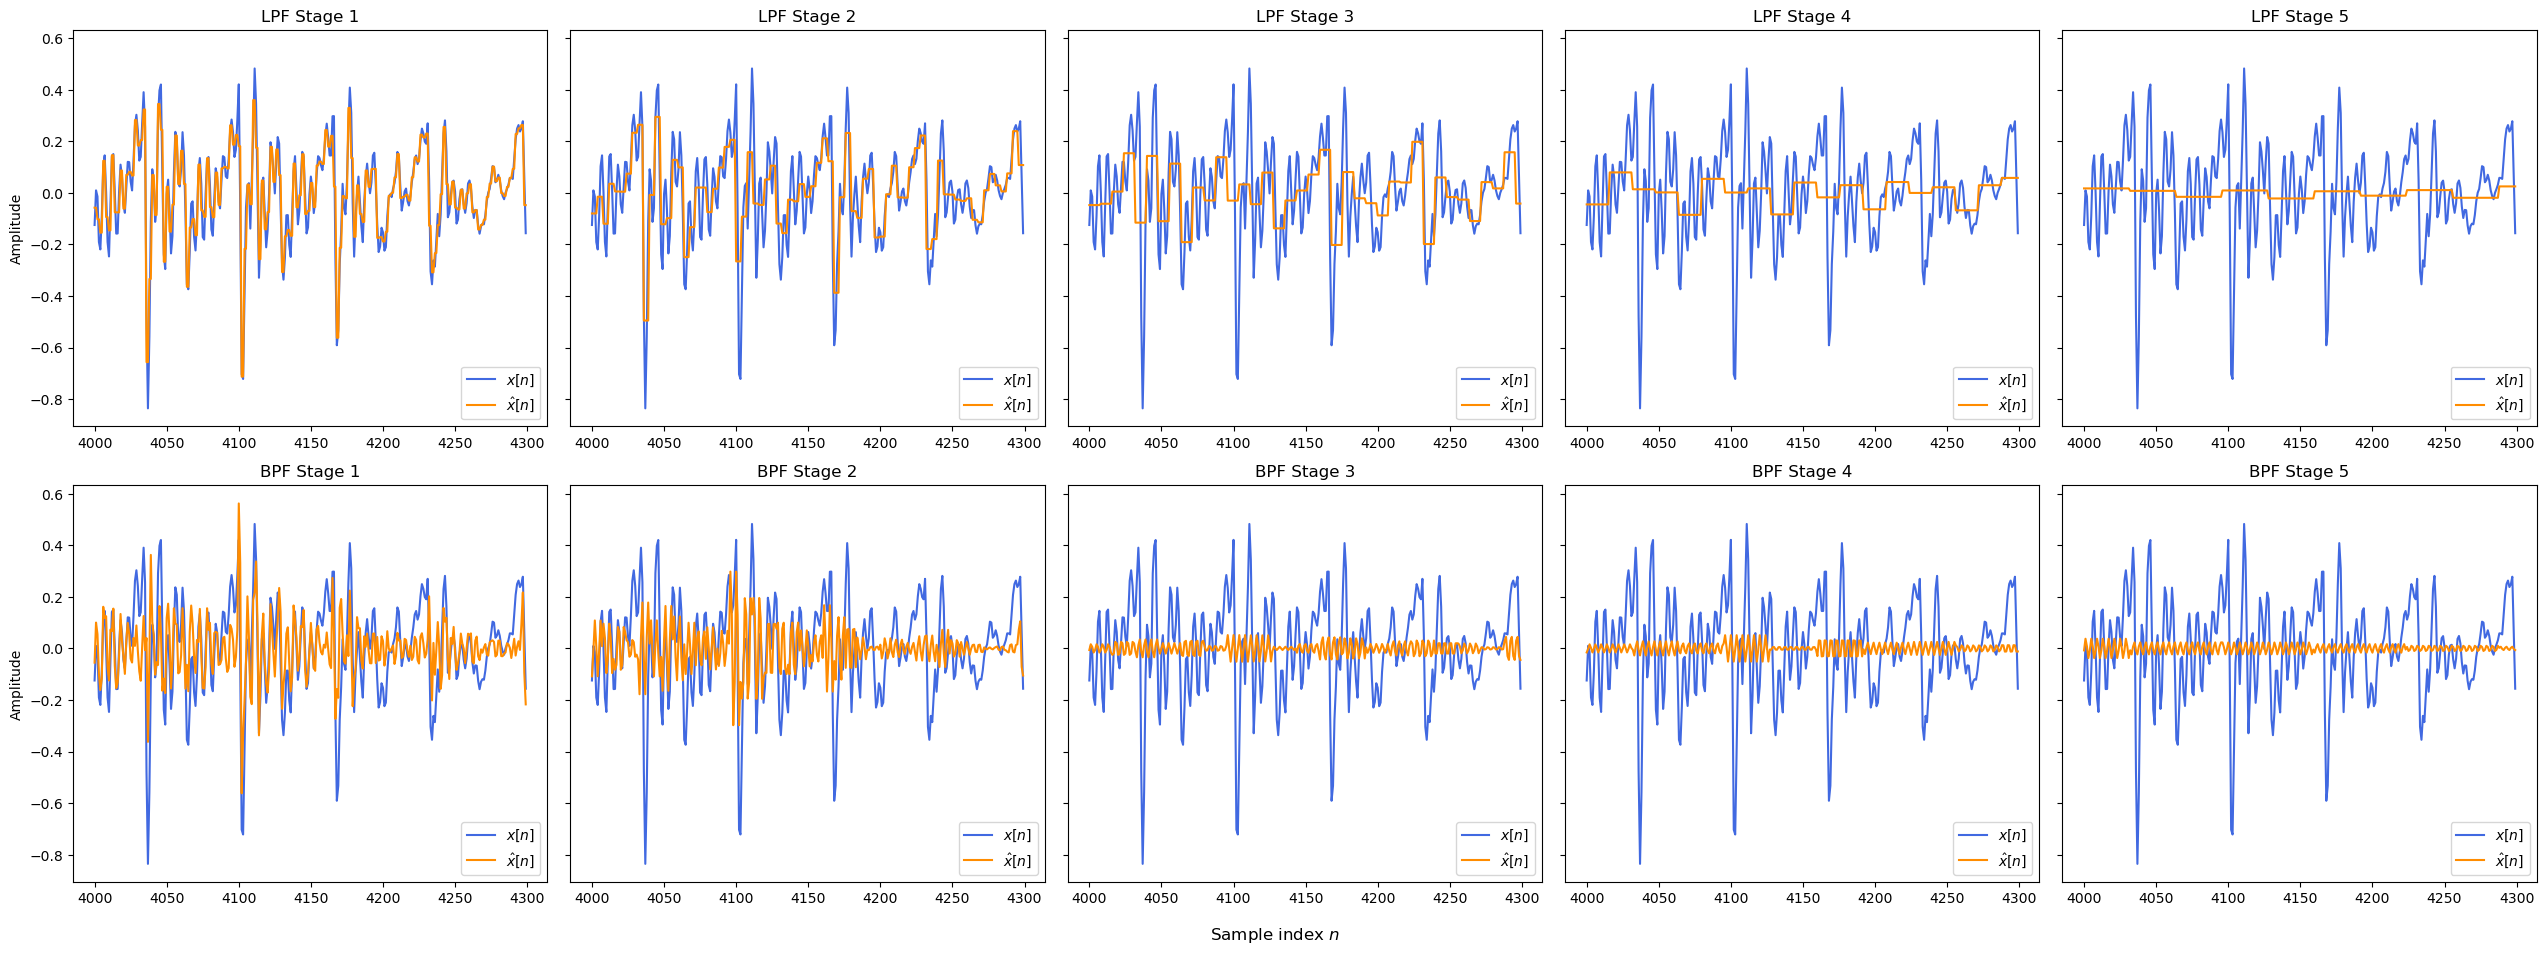

In [45]:
"""
Plot a typical segment of filtered and original signal
"""
fig, axes = plt.subplots(2,5, sharey=True)

# Plot within this range
start = 4000
stop = 4300
n = np.arange(start, stop)

# Plot the lowpass filtered signals in the first row
row = 0
for idx, xlp in enumerate(x_lpf):
    axes[row, idx].plot(n, sound[start:stop], color="royalblue", label=r'$x[n]$')
    axes[row, idx].plot(n, xlp[start:stop], color="darkorange", label=r'$\hat{x}[n]$')
    # axes[row, idx].set_xlabel(r'Sample index $n$')
    # axes[row, idx].set_ylabel('Amplitude')
    axes[row, idx].set_title(f"LPF Stage {idx+1}")
    axes[row, idx].legend(loc='lower right')

# Plot the bandpass filtered signals in the second row
row = 1
for idx, xbp in enumerate(x_bpf):
    axes[row, idx].plot(n, sound[start:stop], color="royalblue", label=r'$x[n]$')
    axes[row, idx].plot(n, xbp[start:stop], color="darkorange", label=r'$\hat{x}[n]$')
    # axes[row, idx].set_xlabel(r'Sample index $n$')
    # axes[row, idx].set_ylabel('Amplitude')
    axes[row, idx].set_title(f"BPF Stage {idx+1}")
    axes[row, idx].legend(loc='lower right')

fig.set_size_inches(6.4*2*2, 4.8*2)
# fig.supylabel("Amplitude")
axes[0,0].set_ylabel('Amplitude')
axes[1,0].set_ylabel('Amplitude')
fig.supxlabel(r"Sample index $n$")
fig.tight_layout()
fig.savefig("hadamard-3" + '.png', dpi=200)
plt.show()

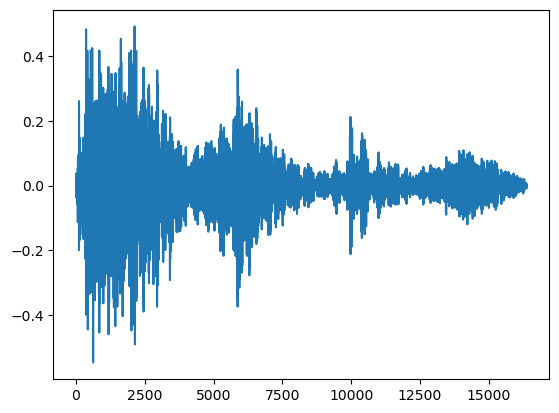

In [38]:
plt.plot(y/np.sqrt(y.size))

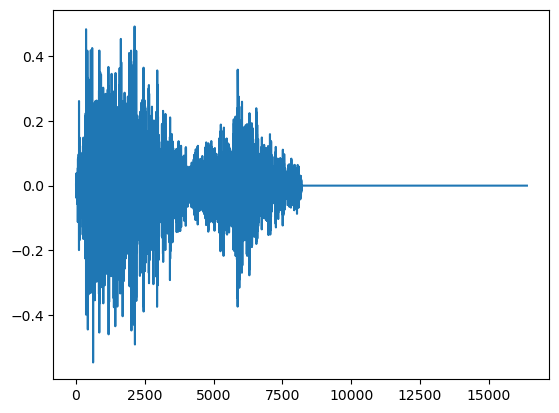

In [72]:
plt.plot(y_lpf[0]/np.sqrt(y.size))

In [74]:
np.sum(np.abs(y/np.sqrt(y.size))**2)

88.95462429523468

In [89]:
# Print the components of the table in the report - formatted
def compute_energy(signal):
    sabs = np.abs(signal/np.sqrt(signal.size))
    return np.sum(sabs**2)

# First line which the total energy
ynrg = compute_energy(y)
print(f"{0} & {ynrg:.2f} & {ynrg/ynrg * 100:.1f} & {ynrg:.2f} & {ynrg/ynrg * 100:.1f} \\\\")

# Rest of the lines
for i in range(len(y_lpf)):
    lpfnrg = compute_energy(y_lpf[i])
    bpfnrg = compute_energy(y_bpf[i])
    print(f"{i+1} & {lpfnrg:.2f} & {lpfnrg/ynrg * 100:.2f} & {bpfnrg:.2f} & {bpfnrg/ynrg * 100:.2f} \\\\")

0 & 88.95 & 100.0 & 88.95 & 100.0 \\
1 & 80.50 & 90.50 & 25.31 & 28.45 \\
2 & 60.44 & 67.94 & 10.02 & 11.26 \\
3 & 37.75 & 42.44 & 1.65 & 1.86 \\
4 & 15.23 & 17.12 & 0.78 & 0.87 \\
5 & 5.57 & 6.26 & 0.38 & 0.43 \\
